In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
import dill
from statsmodels.tsa.seasonal import seasonal_decompose
import random

### Import data and set index

In [344]:
# Load data
data = pd.read_csv(r'C:\Users\ASUS\Jupyter Notebook\walmart-analysis\walmart-analysis\Walmart-Sales-Analysis\Walmart DataSet.csv') 

In [346]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [348]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [350]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


First, we convert the date from type string to datetime and setting it as the index.

In [353]:
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data.set_index('Date', inplace=True)

Next, we check for any null values.

In [356]:
print(data.isna().any(axis = 1).sum())

0


### EDA and Statistical Analysis

<b> a. </b> Weekly Sales vs Unemployment Rate

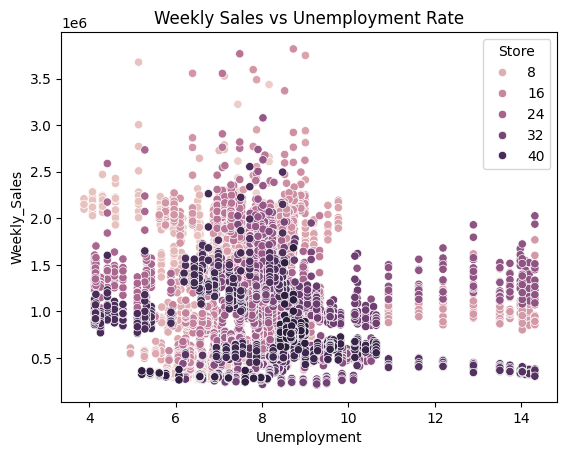

In [360]:
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=data, hue = 'Store')
plt.title('Weekly Sales vs Unemployment Rate')
plt.show()

In [361]:
grouped_data = data.groupby('Store').agg({'Weekly_Sales': 'mean', 'Unemployment' : 'mean'})
avg_weekly_sales = data.Weekly_Sales.mean()
print("Average weekly sales :" , avg_weekly_sales)
high_unemployment_stores = grouped_data.sort_values(by = 'Unemployment', ascending = False).head(5)
high_unemployment_stores

Average weekly sales : 1046964.8775617715


,Weekly_Sales,Unemployment
Store,,
12,1.009002e+06,13.116483
38,3.857317e+05,13.116483
28,1.323522e+06,13.116483
43,6.333247e+05,9.934804
34,9.667816e+05,9.934804


In [364]:
high_unemployment_stores[high_unemployment_stores['Weekly_Sales'] <= avg_weekly_sales]

,Weekly_Sales,Unemployment
Store,,
12,1.009002e+06,13.116483
38,3.857317e+05,13.116483
43,6.333247e+05,9.934804
34,9.667816e+05,9.934804


---
<b> b. </b> Weekly Sales Seasonal Trend

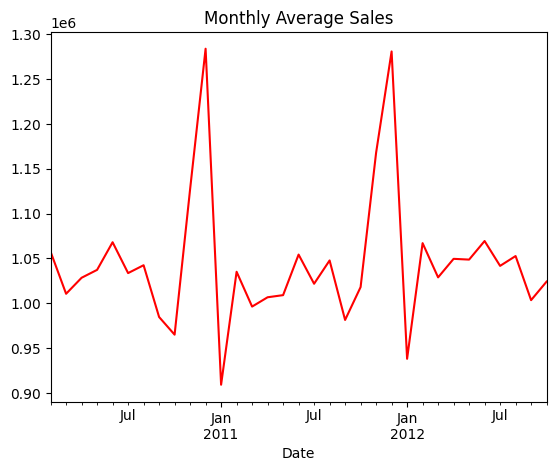

In [367]:
data['Weekly_Sales'].resample('ME').mean().plot(title='Monthly Average Sales', color = "r")
plt.show()

---
<b>c. </b> Weekly Sales vs Temperature

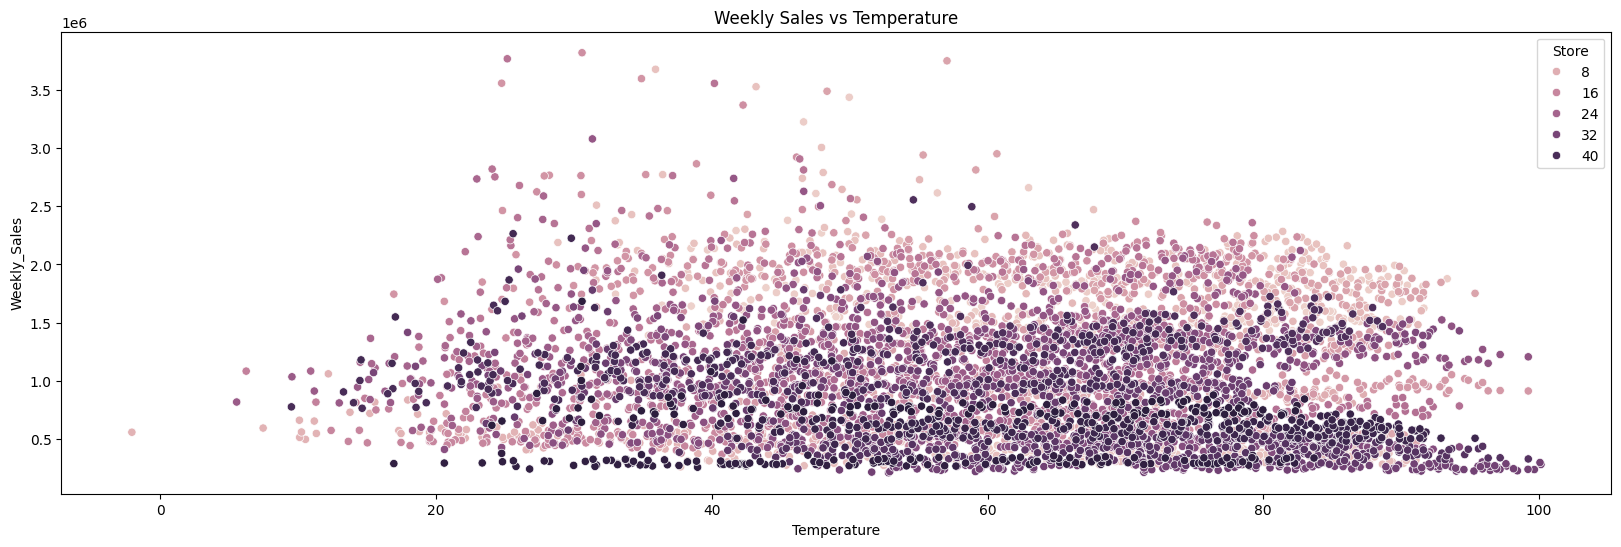

In [370]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data, hue = 'Store')
plt.title('Weekly Sales vs Temperature')
plt.show()


We cannot reasonably assume anything from this graph, there's too many points. We can instead randomly sample some stores and check them for any relationship between them.

In [373]:
store_no1 = data[data["Store"] == random.randint(1, 45)]
store_no2 = data[data["Store"] == random.randint(1, 45)]
store_no3 = data[data["Store"] == random.randint(1, 45)]
store_no4 = data[data["Store"] == random.randint(1, 45)]

In [375]:
store_no1

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,38,358496.14,0,49.47,2.962,126.442065,13.975
2010-02-12,38,342214.90,1,47.87,2.946,126.496258,13.975
2010-02-19,38,327237.92,0,54.83,2.915,126.526286,13.975
2010-02-26,38,334222.73,0,50.23,2.825,126.552286,13.975
2010-03-05,38,372239.89,0,53.77,2.987,126.578286,13.975
...,...,...,...,...,...,...,...
2012-09-28,38,398468.08,0,81.22,3.966,131.043000,10.926
2012-10-05,38,458479.01,0,81.61,3.966,131.075667,10.199
2012-10-12,38,437320.66,0,71.74,4.468,131.108333,10.199


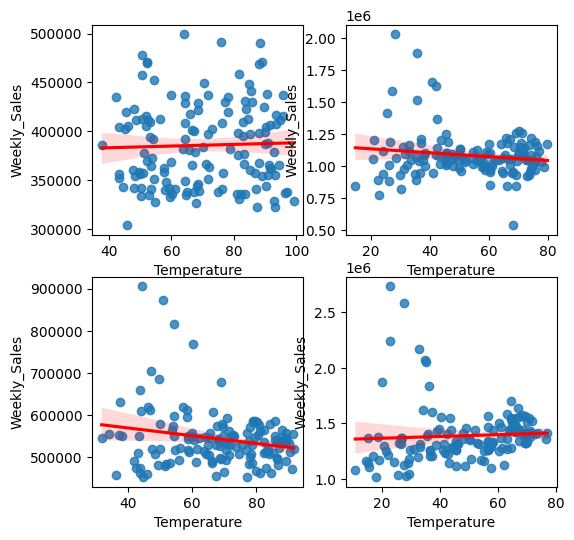

In [377]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

sns.regplot(x = "Temperature", y = "Weekly_Sales", data = store_no1 , ax=ax[0, 0], line_kws={"color": "red"})

sns.regplot(x = "Temperature", y = "Weekly_Sales", data = store_no2 , ax=ax[0, 1], line_kws={"color": "red"})

sns.regplot(x = "Temperature", y = "Weekly_Sales", data = store_no3 , ax=ax[1, 0], line_kws={"color": "red"})

sns.regplot(x = "Temperature", y = "Weekly_Sales", data = store_no4 , ax=ax[1, 1], line_kws={"color": "red"})

plt.show()

No meaningful correlation can be observed: sometimes the temperature has a positive correlation with the weekly sales and at other times it is negative.

---
<b> d. </b> Weekly Sales vs Consumer Price Index (CPI)

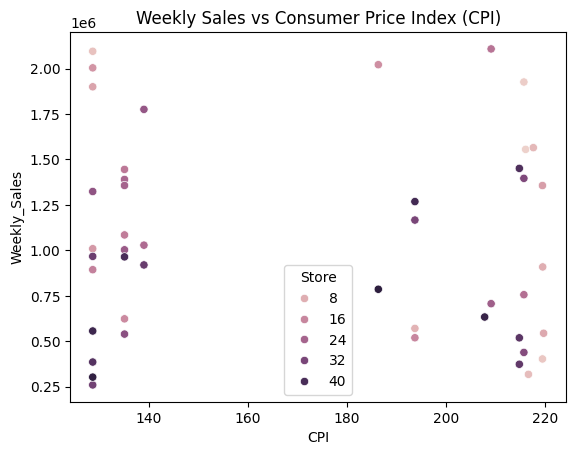

In [381]:
sns.scatterplot(x='CPI', y='Weekly_Sales', data=data.groupby('Store').agg({'Weekly_Sales': 'mean', 'CPI' : 'mean'}), hue = 'Store')
plt.title('Weekly Sales vs Consumer Price Index (CPI)')
plt.show()

---
<b> e. </b> Top performing stores

In [384]:
top_stores = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(5)
print('Top Performing Stores:')
print(top_stores)


Top Performing Stores:
Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
Name: Weekly_Sales, dtype: float64


---
<b> f. </b> Worst performing store

In [387]:
worst_store = data.groupby('Store')['Weekly_Sales'].sum().idxmin()
print()
print('Worst Performing Store:', worst_store)


Worst Performing Store: 33


In [389]:
def adfuller_test(sales_amount):
    result = adfuller(sales_amount)
    labels = ['ADF Test-statistic', 'p-value', 'Lags Used', 'Observations Used']
    #for label, value in zip(labels, result):
        #print(label, ":", value)
    if result[1] < 0.05:
        return("Stationary")
    else:
        return("Non-stationary.")

In [391]:
grouped_data = data.groupby(['Store','Date']).agg({'Weekly_Sales': 'mean'})

In [393]:
sales1 = data[data['Store'] == 1][['Weekly_Sales']]

In [395]:
sales1

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68
...,...
2012-09-28,1437059.26
2012-10-05,1670785.97
2012-10-12,1573072.81


<Figure size 1200x500 with 0 Axes>

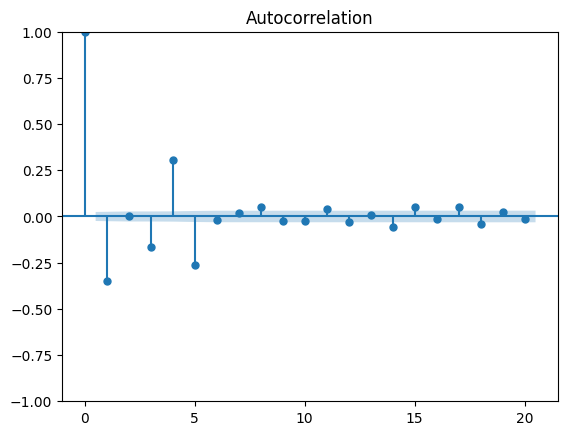

In [397]:
plt.figure(figsize=(12, 5))
plot_acf(data['Weekly_Sales'].diff().dropna(), lags=20)  # ACF for q
plt.show()

<Figure size 1200x500 with 0 Axes>

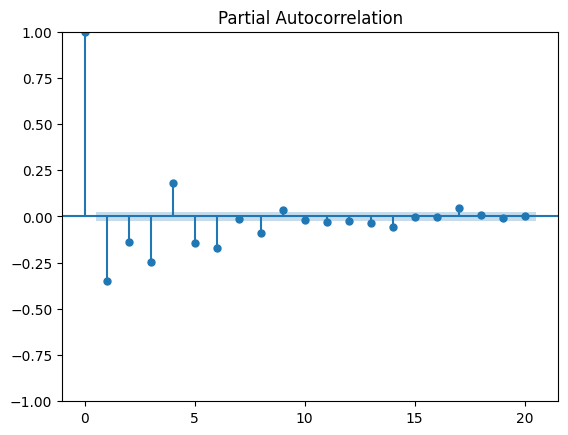

In [399]:
plt.figure(figsize=(12, 5))
plot_pacf(data['Weekly_Sales'].diff().dropna(), lags=20)  # PACF for p
plt.show()

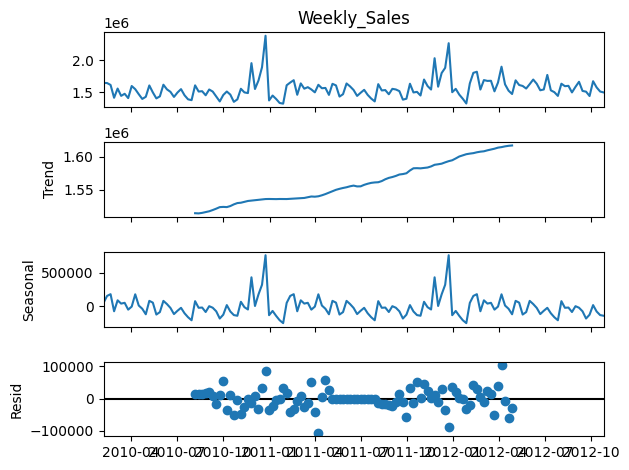

In [401]:
decomposed = seasonal_decompose(sales1['Weekly_Sales'], period=52)  # Adjust `period`
decomposed.plot()
plt.show()

In [403]:
import itertools

In [405]:
p = range(0, 8)
q = range(0, 8)
d = range(0, 2)

In [407]:
pdq_combination = list(itertools.product(p,d,q))

In [409]:
len(pdq_combination)

128

In [411]:
min_pdq_values = []

In [413]:
import warnings

In [318]:
warnings.filterwarnings('ignore')
for i in range(1, 46):
    sales = data[data['Store'] == i][['Weekly_Sales']]
    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        train = sales[:114]
        test = sales[114:]
        min_value = 1000000
        print(len(sales))
        minp, minq, mind = 0, 0, 0
        for p, d, q in pdq_combination:
            model = ARIMA(train, order = (p, d, q))
            result = model.fit()
            prediction = result.predict(start = 114, end = len(sales) - 1)
            rmse = np.sqrt(mean_squared_error(test, prediction))
            if (rmse < min_value):
                minp, minq, mind = p, q, d
                min_value = rmse
    else:
        print("Unable to process : Store number ", i)
    print("(", minp, ",", mind, ",", minq, ") :", min_value)
    min_pdq_values.append((minp, mind, minq))

143
( 2 , 0 , 7 ) : 78194.83655472752
143
( 4 , 1 , 2 ) : 78247.31595869699
143
( 4 , 0 , 1 ) : 19106.98276410227
143
( 3 , 0 , 2 ) : 73490.79456269418
143
( 4 , 0 , 1 ) : 15419.992375119695
143
( 0 , 0 , 1 ) : 107416.11320970129
143
( 6 , 1 , 7 ) : 87157.70583759774
143
( 0 , 0 , 0 ) : 30617.587530372522
143
( 4 , 0 , 0 ) : 25494.51503069089
143
( 4 , 1 , 2 ) : 145293.829142581
143
( 2 , 0 , 2 ) : 69506.79399422853
143
( 5 , 1 , 6 ) : 50919.06974636004
143
( 4 , 1 , 2 ) : 80744.87483326376
Unable to process : Store number  14
( 4 , 1 , 2 ) : 80744.87483326376
143
( 0 , 1 , 2 ) : 46329.363457167776
143
( 6 , 1 , 6 ) : 52665.31080966926
143
( 1 , 1 , 0 ) : 81057.68392127783
143
( 4 , 1 , 3 ) : 65805.78768242087
143
( 0 , 1 , 2 ) : 94700.77197377227
143
( 0 , 0 , 0 ) : 110125.52774772324
143
( 0 , 1 , 1 ) : 67991.37263815729
143
( 0 , 0 , 0 ) : 61053.169872860504
143
( 0 , 0 , 0 ) : 116492.89249859368
143
( 3 , 1 , 0 ) : 97104.87402322766
143
( 0 , 0 , 0 ) : 33481.13047445728
143
( 4 , 1

I seem to have lost the code I used to identify this seasonal_order for SARIMAX but I brute forced it over a range specified for p, d, q, P, D, Q, where the small letters denote the AR/difference/MA order whereas the capital letters denote the seasonal order. My laptop is facing some issues so I'm unable to run the code overnight again.

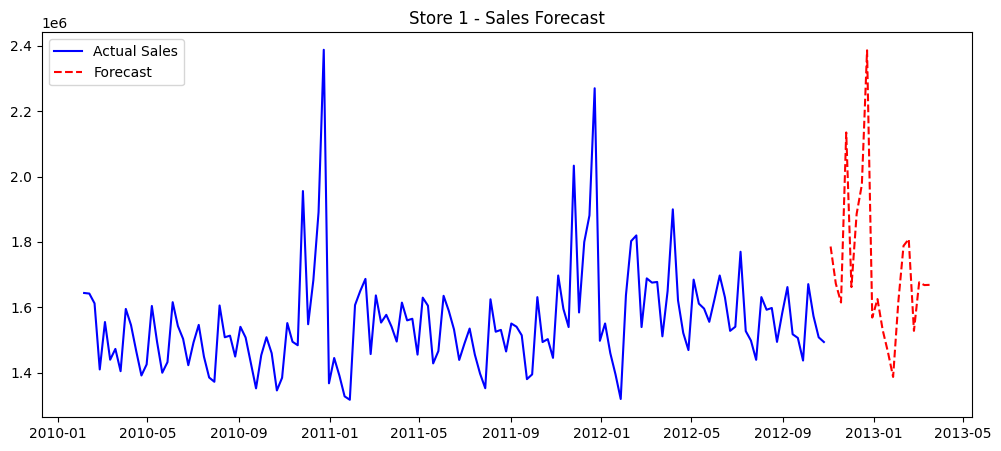

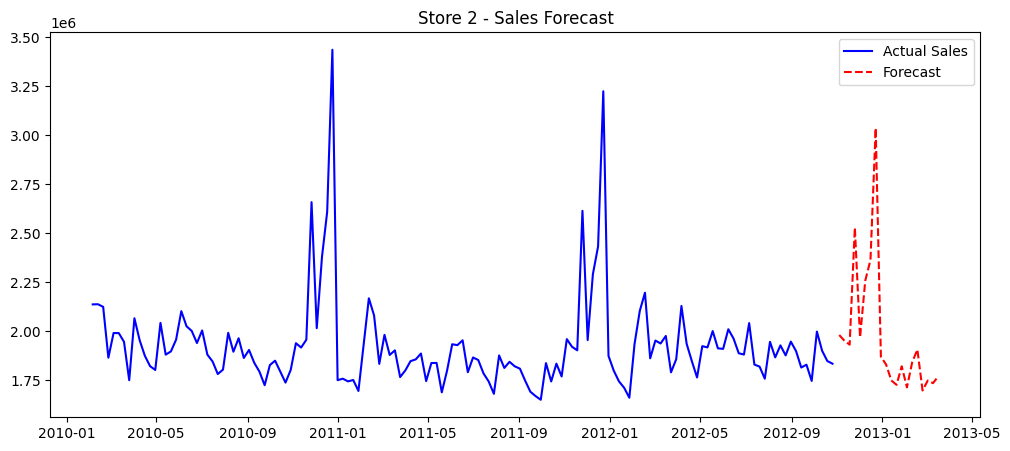

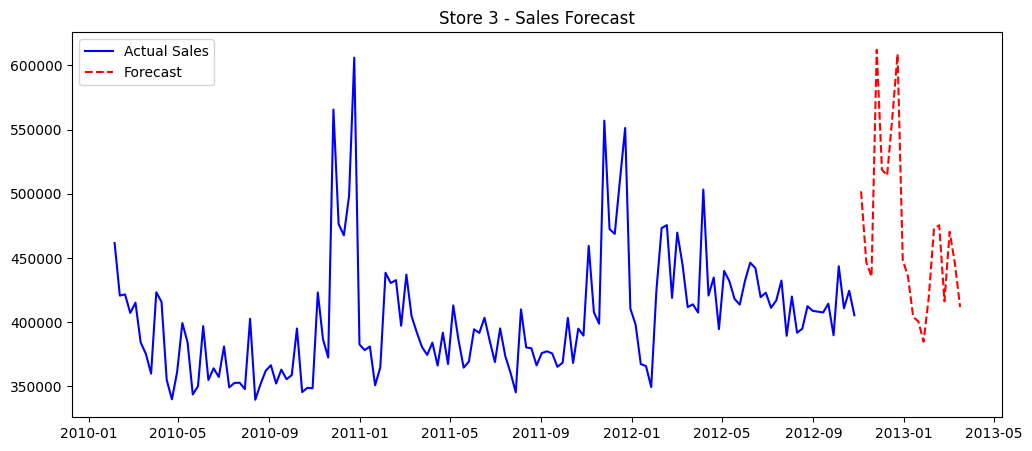

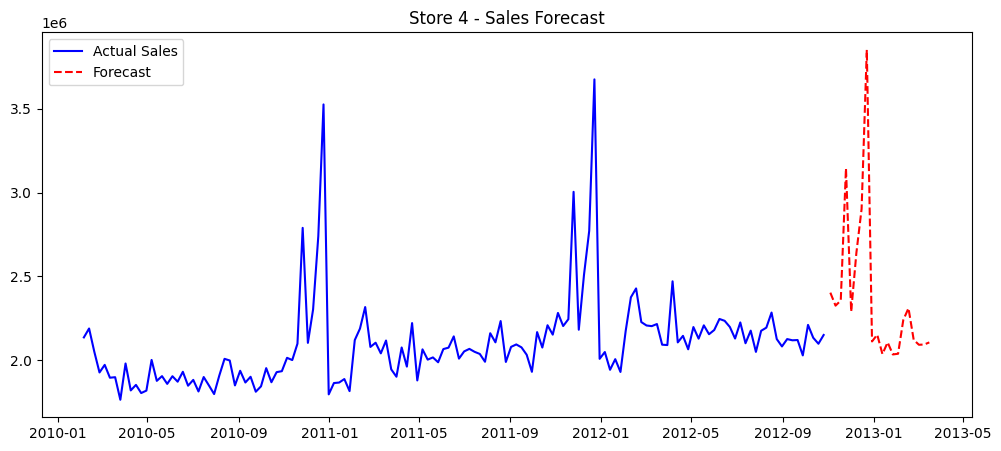

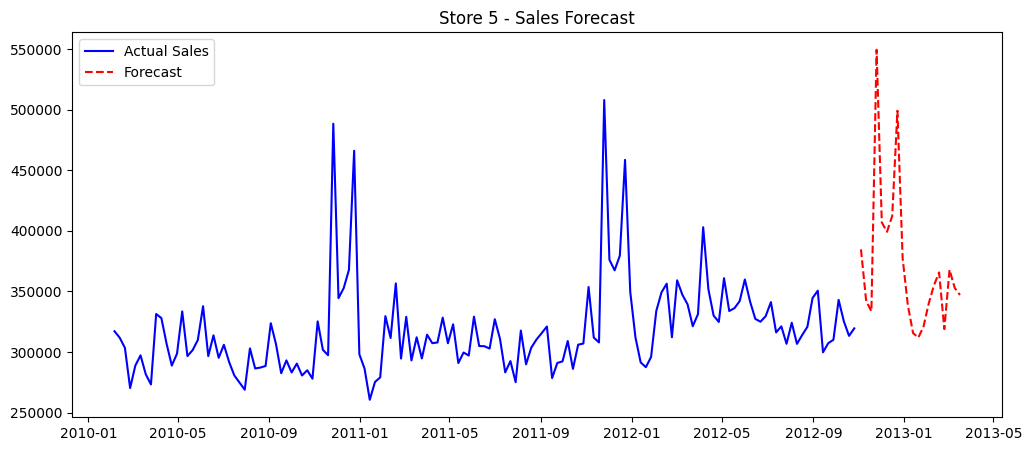

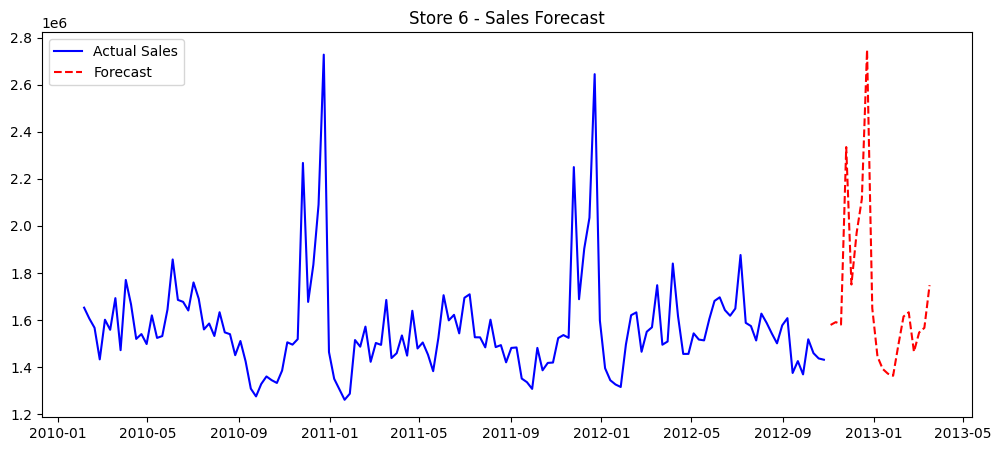

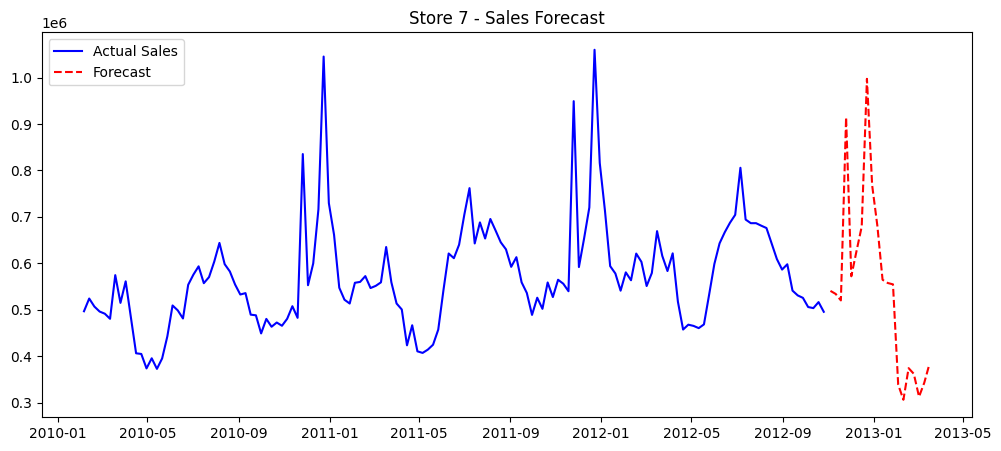

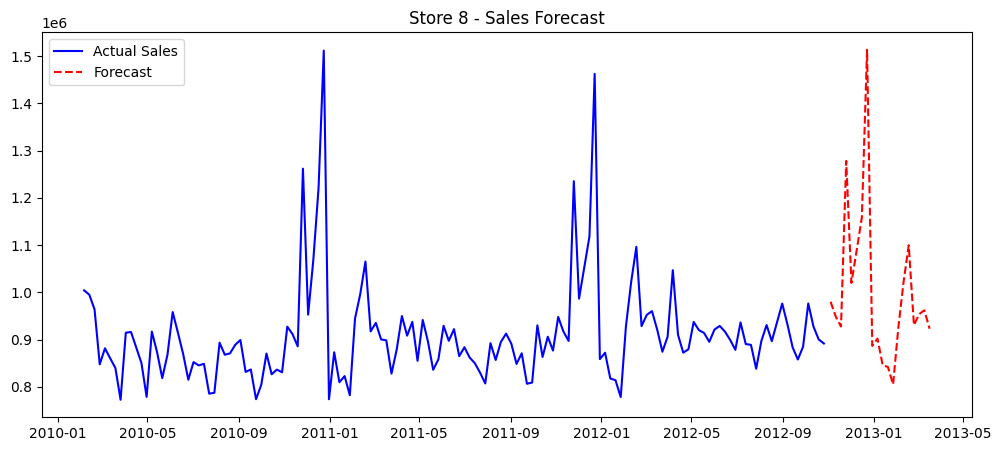

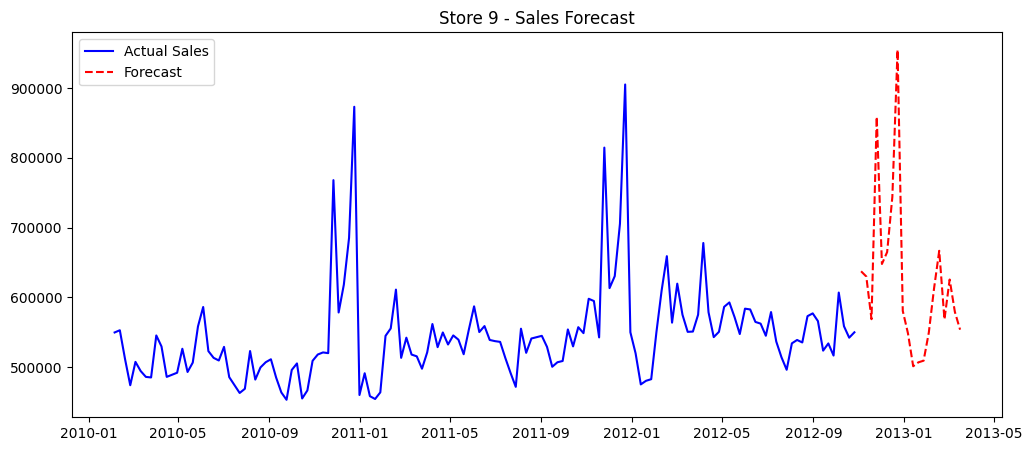

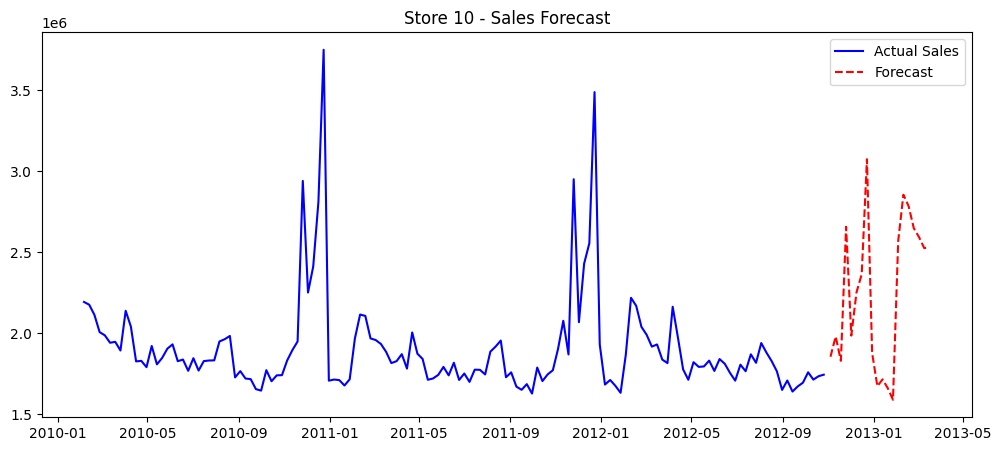

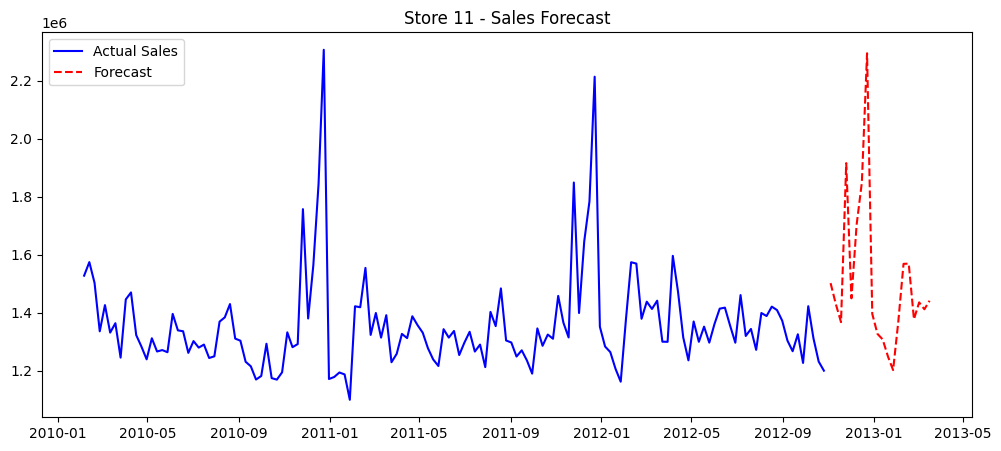

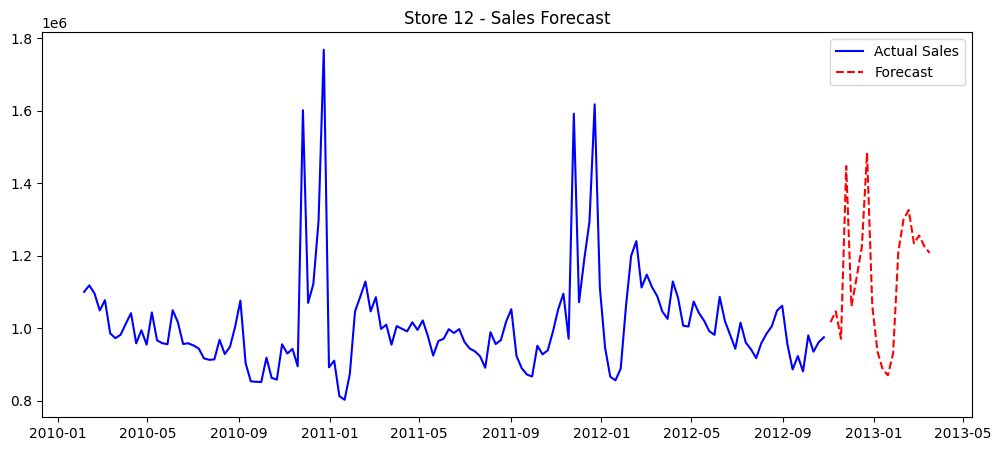

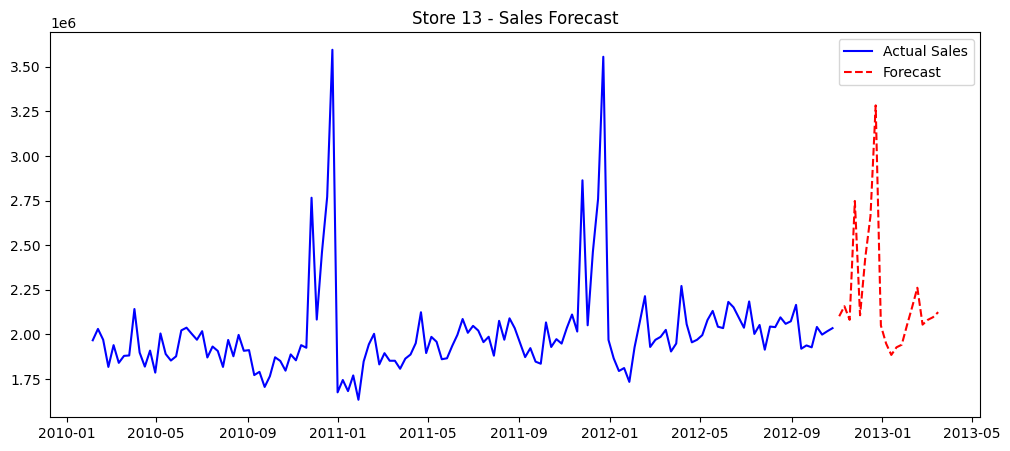

Unable to process: Store number 14


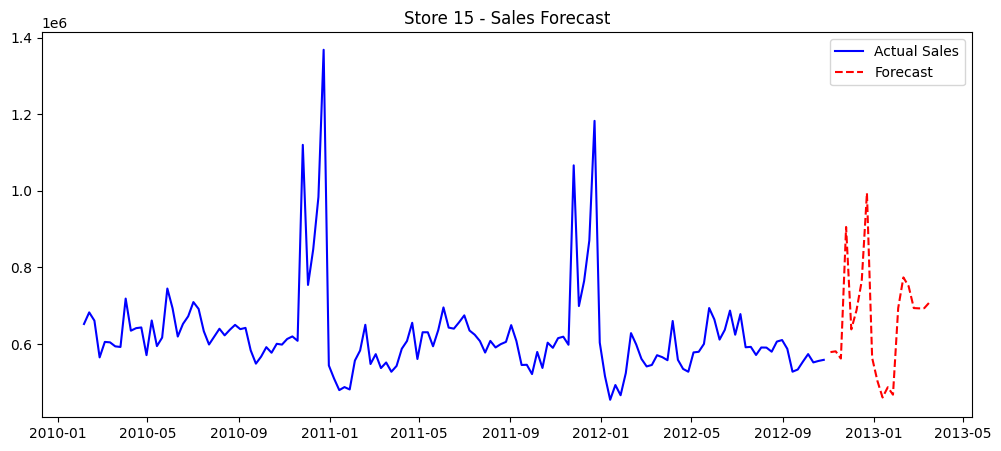

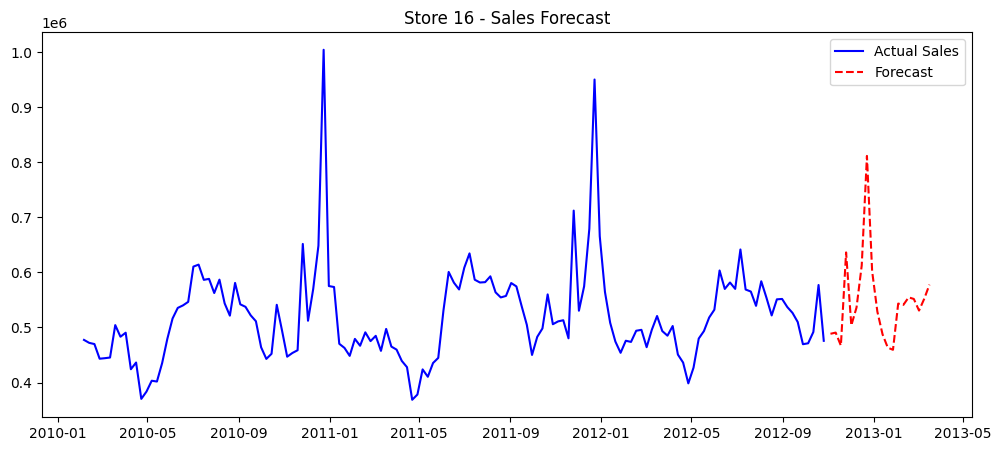

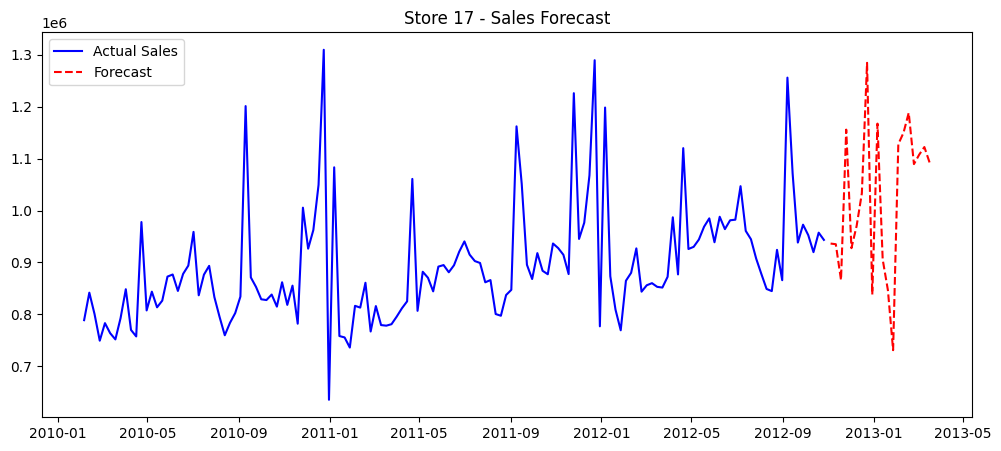

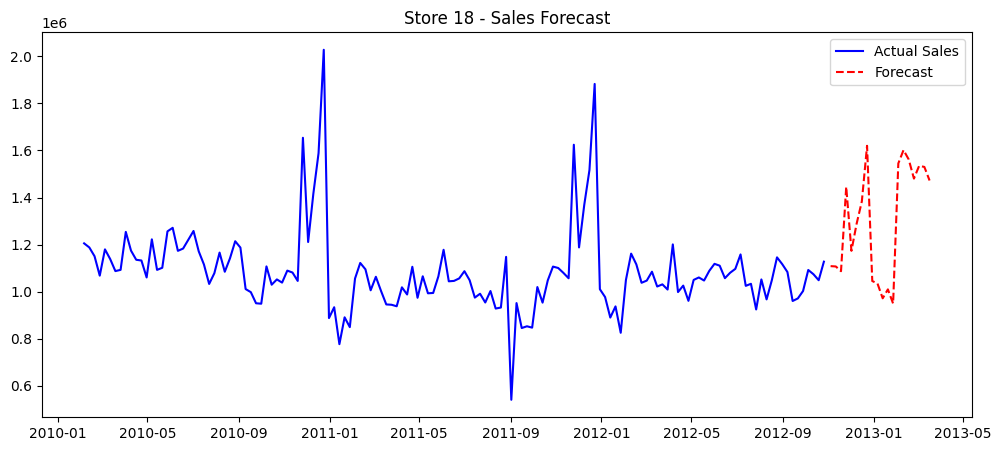

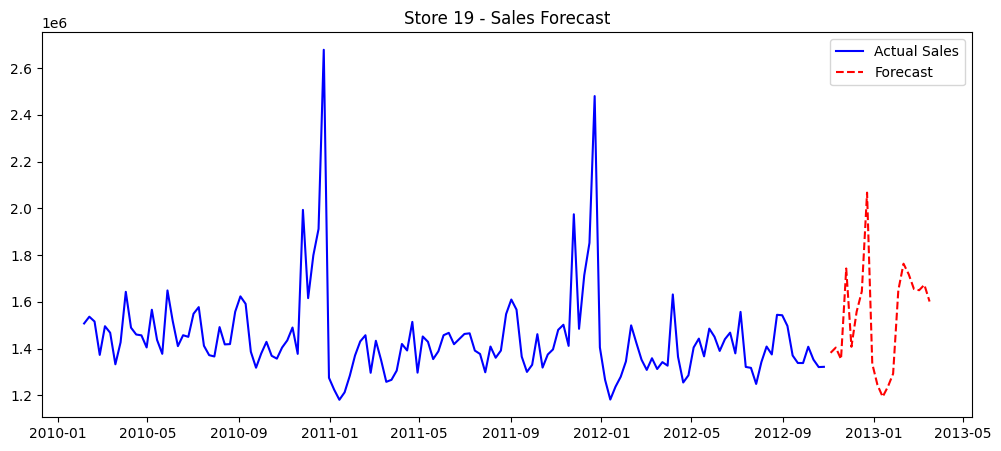

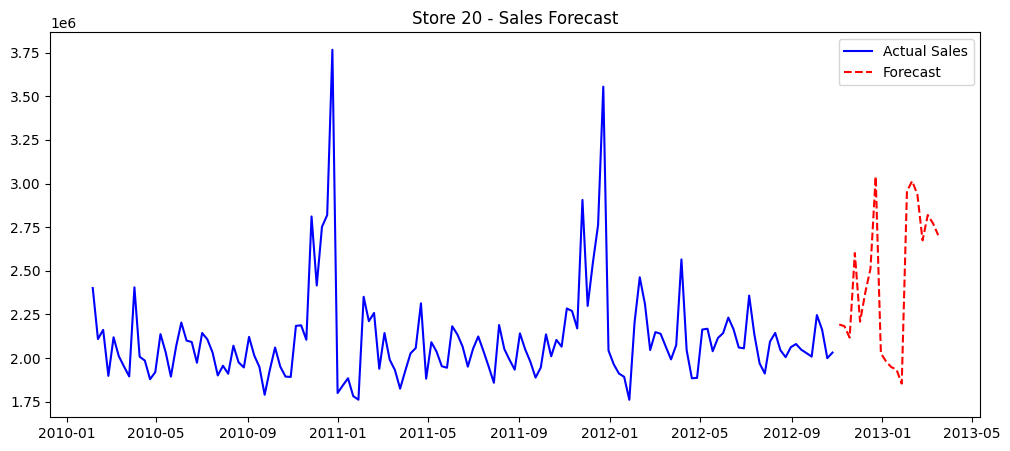

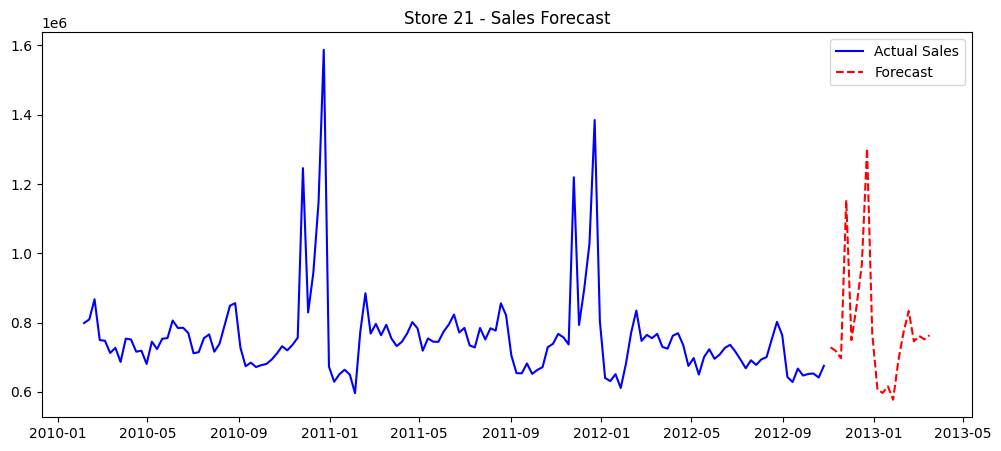

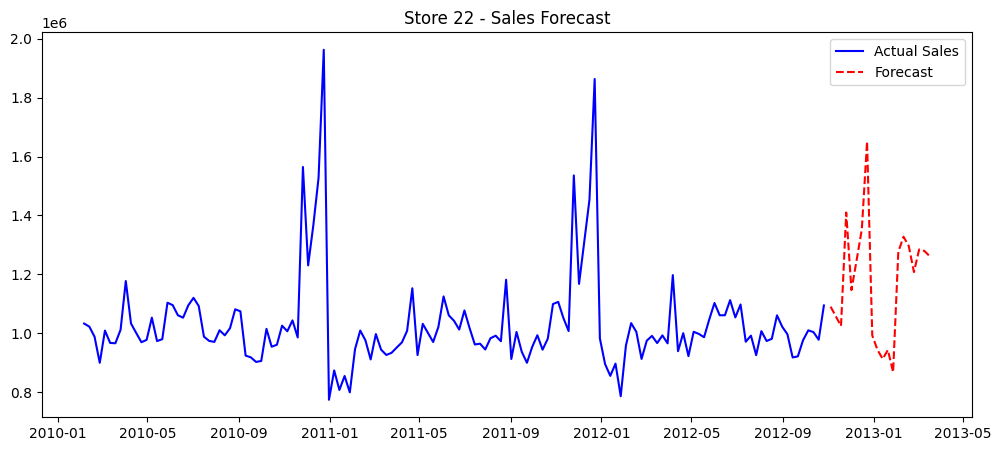

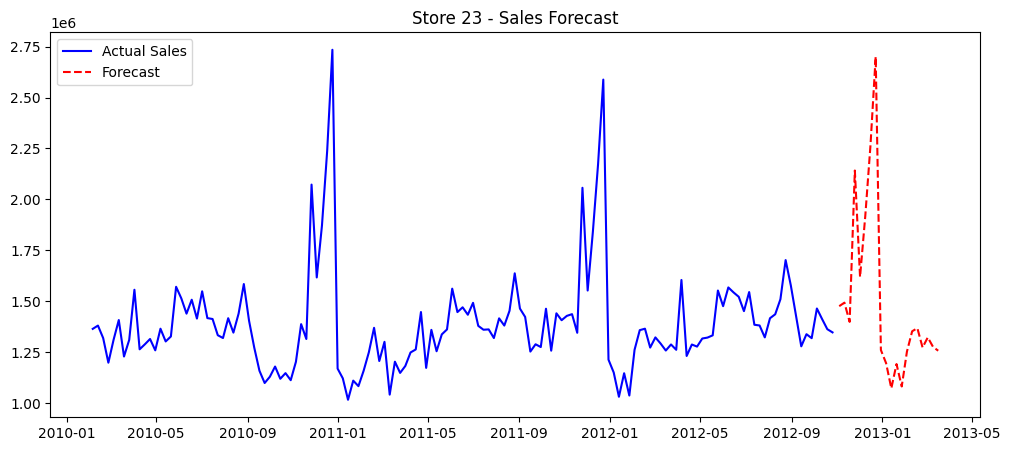

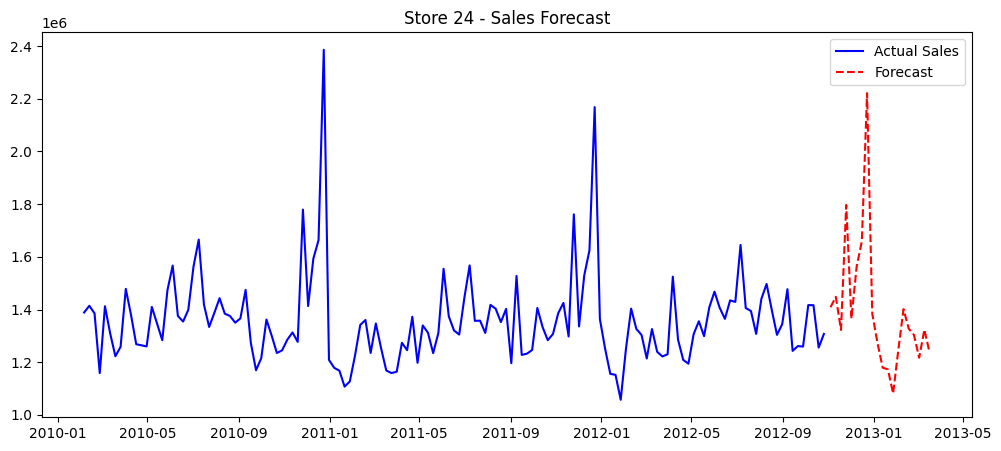

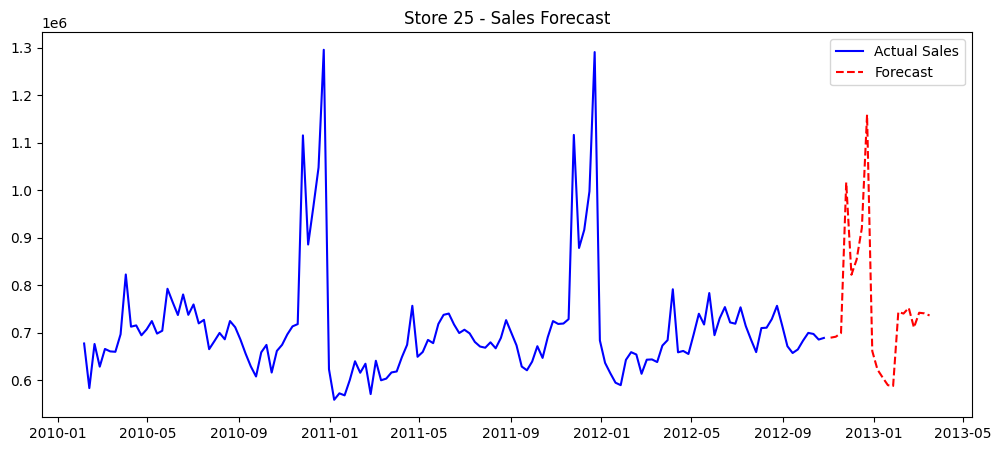

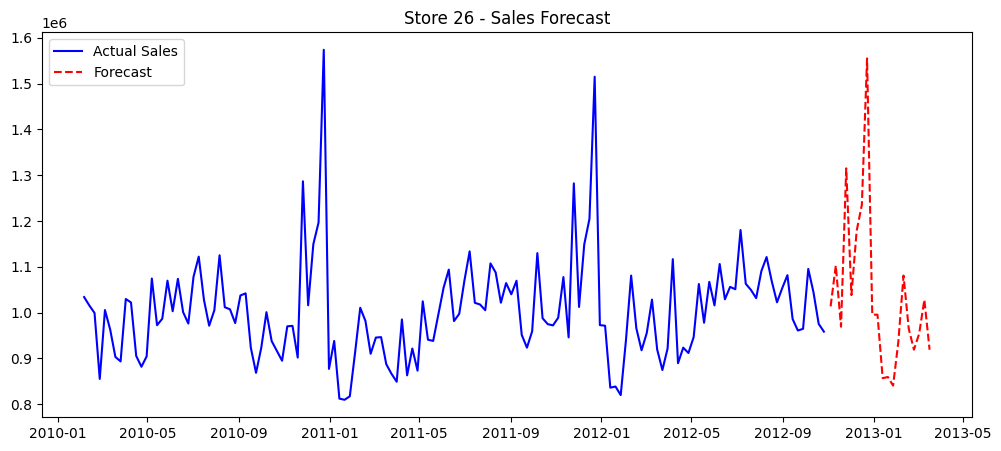

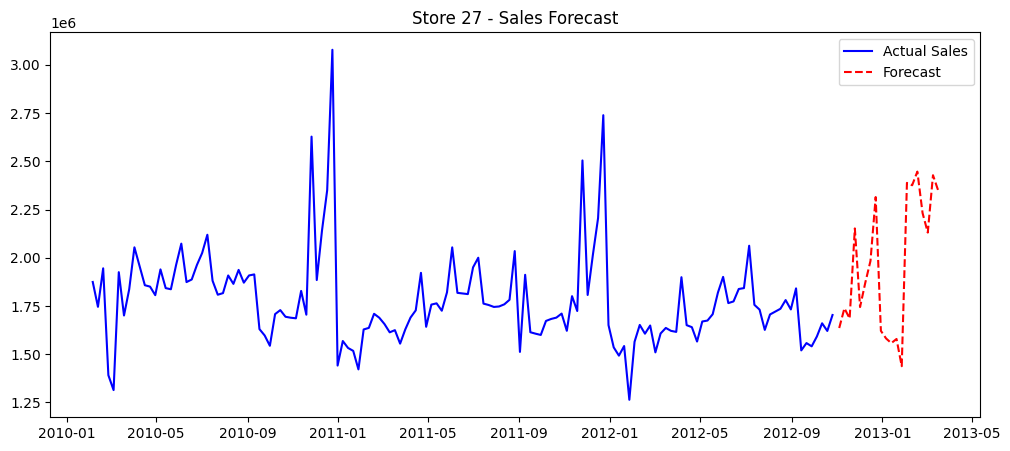

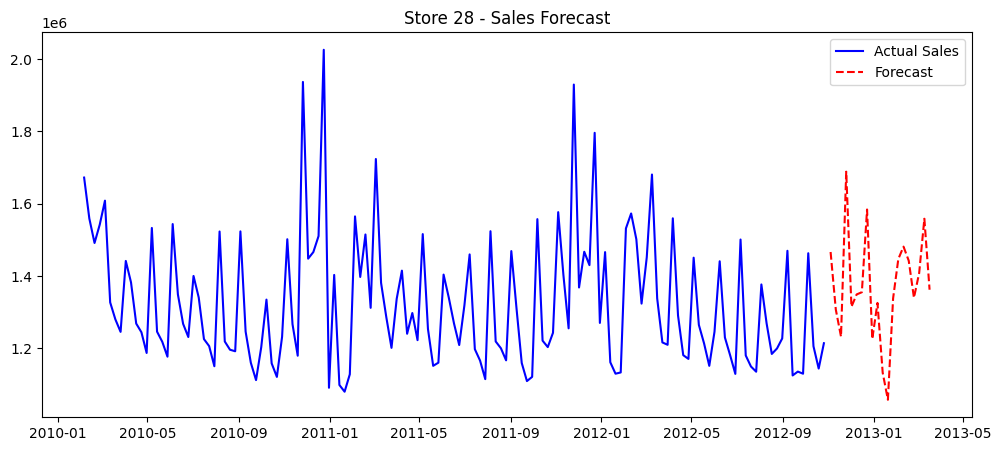

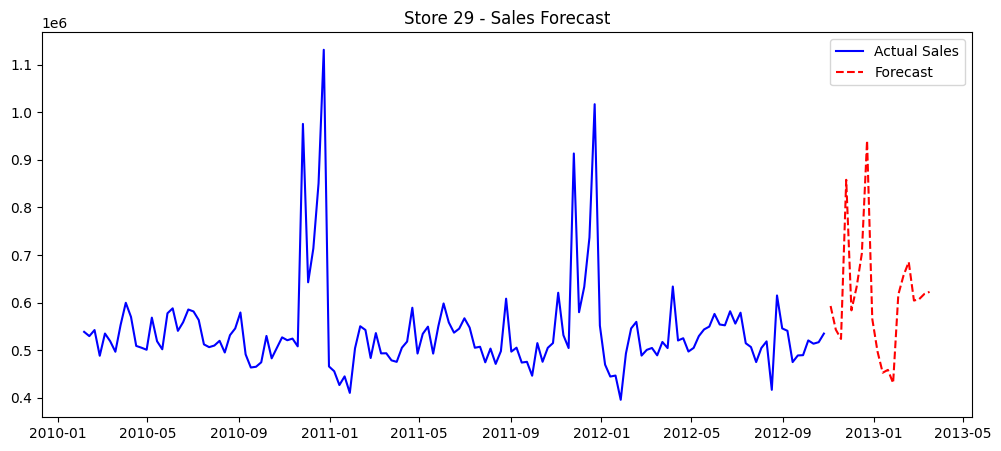

Unable to process: Store number 30


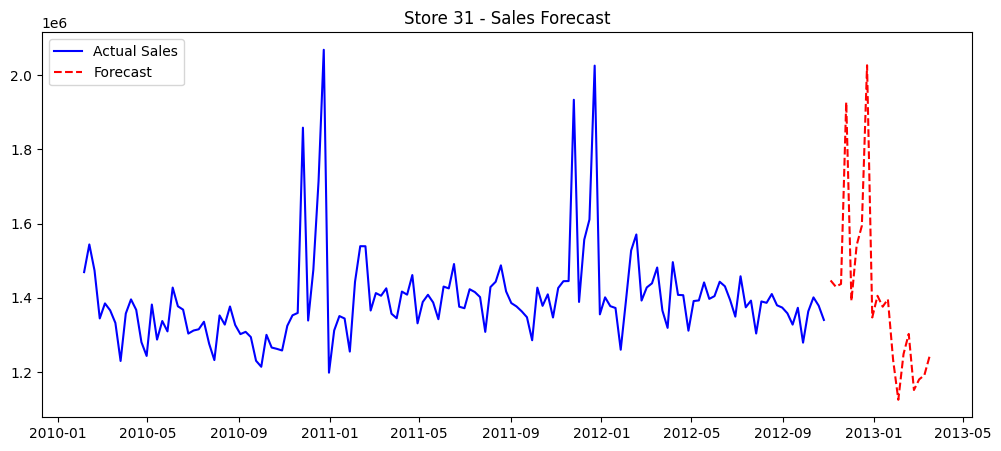

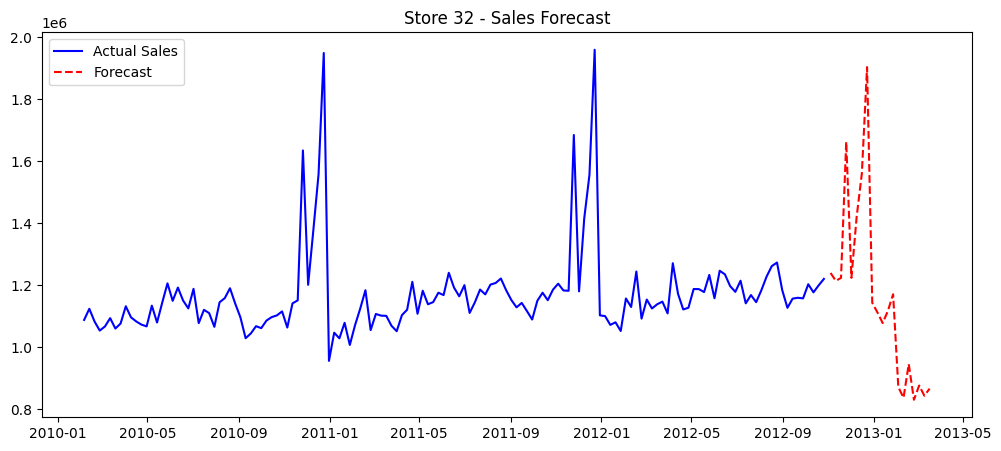

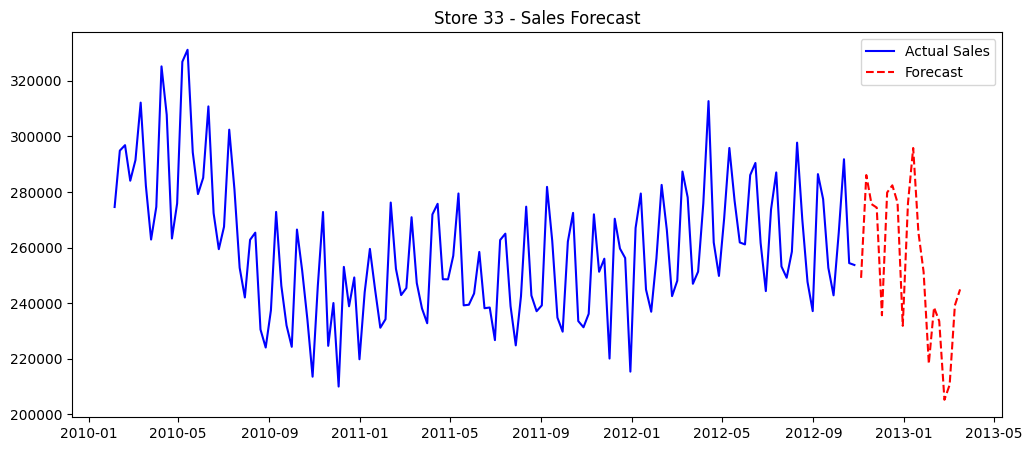

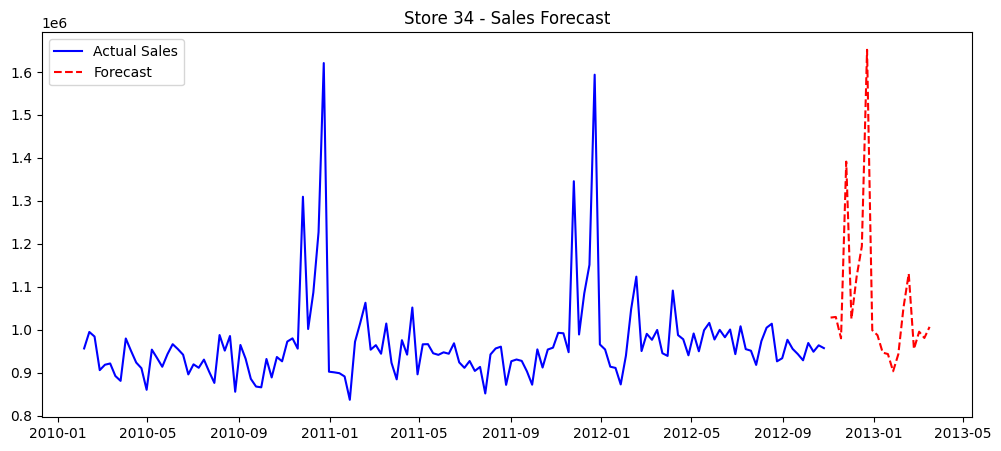

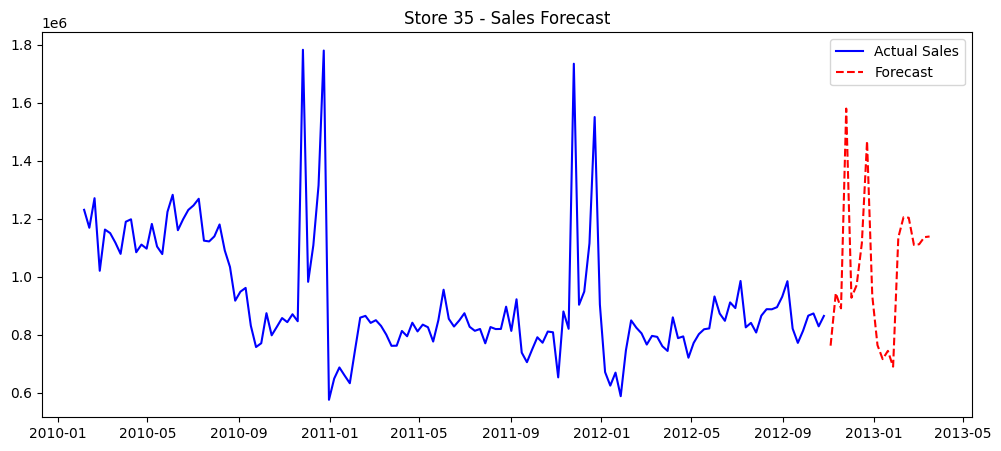

Unable to process: Store number 36


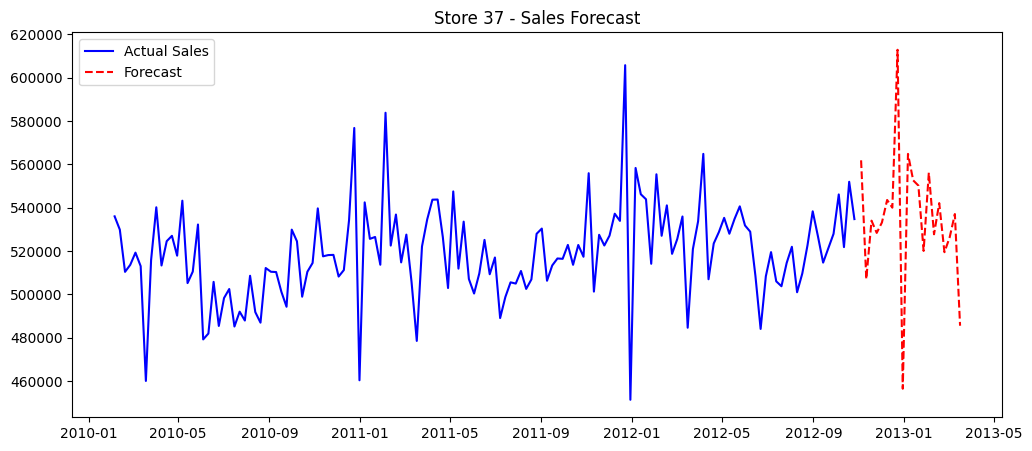

Unable to process: Store number 38


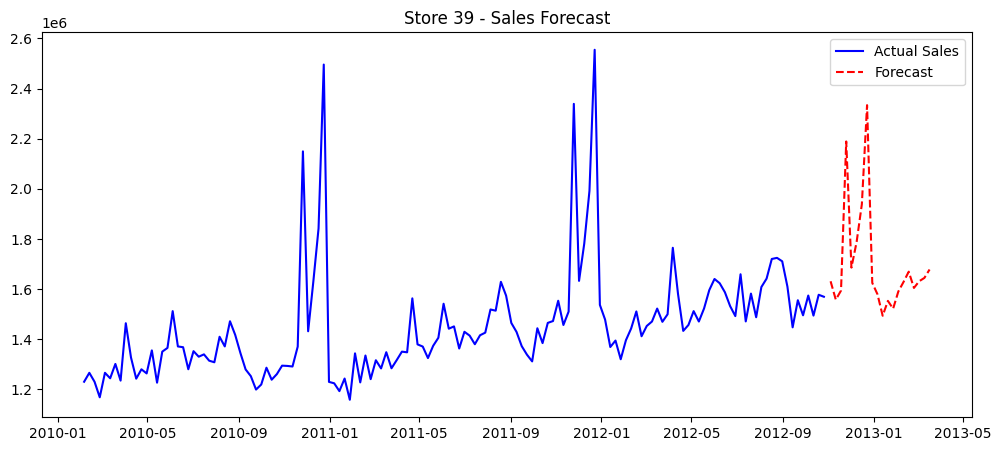

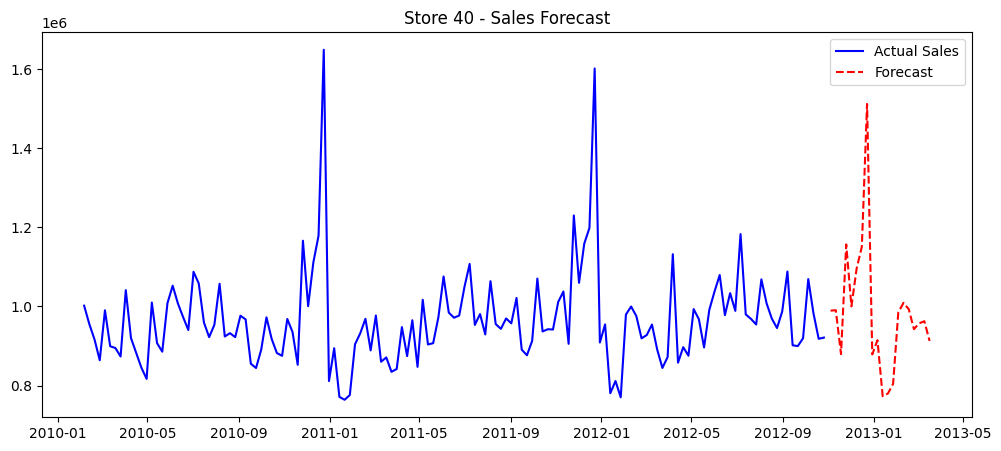

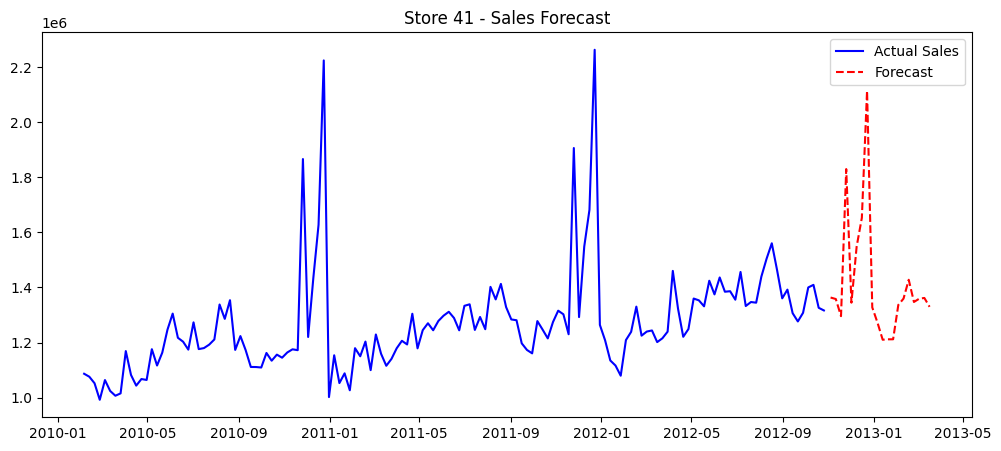

Unable to process: Store number 42
Unable to process: Store number 43
Unable to process: Store number 44


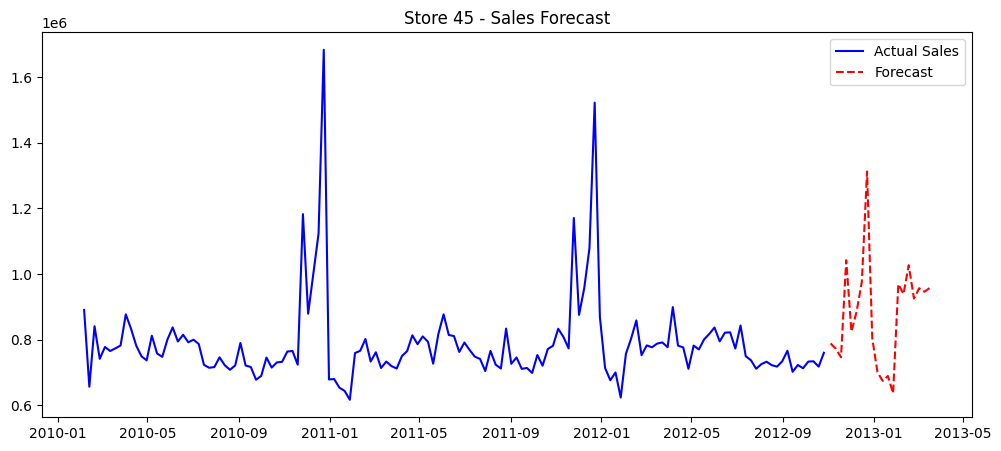

In [439]:
for i in range(1, 46):
    sales = data[data['Store'] == i][['Weekly_Sales']].dropna()  # Remove NaN values

    if adfuller_test(sales['Weekly_Sales']) == 'Stationary':
        try:
            p, d, q = min_pdq_values[i - 1]
    
            # Smaller model first
            model = SARIMAX(sales, order=(p, d, q), seasonal_order=(4, 1, 2, 52))
    
            # Fit with constraints
            result = model.fit(disp=0, maxiter=200, method='lbfgs')
    
            # Forecasting
            future_dates = pd.date_range(start=sales.index[-1], periods=21, freq='W')[1:]
            forecast_values = result.forecast(steps=20)
    
            # Plot results
            plt.figure(figsize=(12, 5))
            plt.plot(sales.index, sales['Weekly_Sales'], label='Actual Sales', color='blue')
            plt.plot(future_dates, forecast_values, label='Forecast', color='red', linestyle='dashed')
    
            plt.title(f'Store {i} - Sales Forecast')
            plt.legend()
            plt.show()
            
        except Exception as e:
            print(f"Store {i} - Model fitting error: {str(e)}")

    else:
        print("Unable to process: Store number", i)

In [441]:
import dill

In [447]:
dill.dump_session("stuff.db")